<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-Network-Class" data-toc-modified-id="Neural-Network-Class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural Network Class</a></span></li><li><span><a href="#QSAR-aquatic-toxicity-Data-Set" data-toc-modified-id="QSAR-aquatic-toxicity-Data-Set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>QSAR aquatic toxicity Data Set</a></span></li><li><span><a href="#Grading" data-toc-modified-id="Grading-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Grading</a></span></li><li><span><a href="#Check-In" data-toc-modified-id="Check-In-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Check-In</a></span></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

ANJU GOPINATH

# Neural Network Class

* A3.3: *Modified `A3grader.tar` to correctly grade the `error_trace` value.  It now assumes you use the following function for the `error_convert_f`:

        def error_convert(err):
            if T.shape[1] == 1:
                return np.sqrt(err) * self.stand_params['Tstds']
            else:
                # Can't unstandardize err if more than one network output
                return np.sqrt(err)

* A3.2: *Added `A3grader.py` and additional requirements involving application of your `NeuralNetwork` class to a specific data set.*
* A3.1: *Added some details on specifications of required functions and many examples of running your implementation.*

You will define a new class named `NeuralNetwork` that constructs a neural network with any number of hidden layers.  To train the neural network, you will use our `optimizers.py` code. Use this updated version: [optimizers.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/optimizers.tar).  Your class must implement at least the following functions. Lecture Notes 07 provide examples of some of the code in the section about using `Optimizers` on which you can base your implementation.

* `__init__(self, n_inputs, n_hiddens_list, n_outputs)`: 
* `__repr__(self):`
* `make_weights(self):` called from constructor `__init__`
* `initialize_weights(self):` called from constructor `__init__`
* `train(self, X, T, n_epochs, learning_rate, method='adam', verbose=True):` `method` can be 'sgd', 'adam', or 'scg'. Must first calculate standarization parameters, stored in `stand_params` dictionary, and standardize `X` and `T`.  Import `optimizers.py` and use these optimizers in this `train` function. Use the `tanh` activation function.
* `use(self, X, return_hidden_layer_outputs=False):` standardizes X then calculates the output of the network by calling `forward` and unstandardizing the network output. Returns just the output of the last layer. If `return_hidden_layer_outputs` is `True`, return two things, the output of the last layer and a list of outputs from each hidden layer.
* `get_error_trace(self):` just returns the `error_trace`

Here are some example uses of your `NeuralNetwork` class.  Your implementation should return very close to the same values in each code cell.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt

In [2]:
class NeuralNetwork():

    def __init__(self,n_inputs,n_hiddens_list,n_outputs):
        self.n_inputs =  n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs =  n_outputs
        #weights
        self.all_weights, self.Ws = self.make_weights()
        self.initialize_weights()
        #gradients
        self.all_gradients, self.Gs = self.make_gradients()
        
        #error_trace and stand_params
        self.error_trace = None
        self.stand_params = None
        self.n_layers=len(self.n_hiddens_list)+1
        
        
    def __repr__(self): 
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, {self.n_outputs})'
    
    def initialize_weights(self): 
        #V[:] = np.random.uniform(-1, 1, size=(1 + n_inputs, n_hiddens)) / np.sqrt(n_inputs + 1)
        #W[:] = np.random.uniform(-1, 1, size=(1 + n_hiddens, n_outputs)) / np.sqrt(n_hiddens + 1)
                
        Ws=[]
        Ws.append(self.n_inputs)
        for i in range(len(self.n_hiddens_list)):
            Ws.append(self.n_hiddens_list[i])
        Ws.append(self.n_outputs)
        for i in range(len(Ws)-1):
            self.Ws[i][:]= np.random.uniform(-1, 1, size=(1 + Ws[i], Ws[i+1])) / np.sqrt(Ws[i] + 1)

            
    def make_gradients(self):
        return self.make_weights()
         
    def make_weights(self):
        Ws=[]
        Ws.append(self.n_inputs)
        for i in range(len(self.n_hiddens_list)):
            Ws.append(self.n_hiddens_list[i])
        Ws.append(self.n_outputs)
       
        nw=0
        for i in range(len(Ws)-1):
            nw=nw+((Ws[i]+1)*Ws[i+1])
        all_weights = np.zeros(nw)
       
        first=0
        W=[]
        for i in range(len(Ws)-1):
            n_w_this_layer = (1+Ws[i])*Ws[i+1]
            T= all_weights[first:first + n_w_this_layer].reshape(1+Ws[i],Ws[i+1])
            W.append(T)
            first += n_w_this_layer
        return all_weights,W
         
    def train(self, X, T, n_epochs, learning_rate, method, verbose=False):
        self.stand_params = self.calc_standardize_parameters(X, T)
        # Standardize X and T.
        Xst = self.standardize_X(X, self.stand_params)
        Tst = self.standardize_T(T, self.stand_params)
        optimizer = opt.Optimizers(self.all_weights)
        if method == 'adam':
            self.error_trace = optimizer.adam(self.mse, self.backward, [Xst, Tst], n_epochs, learning_rate,verbose=False,
                                 error_convert_f=self.error_convert)
        elif method == 'sgd':
            self.error_trace = optimizer.sgd(self.mse, self.backward, [Xst, Tst], n_epochs, learning_rate,verbose=False, 
                                 error_convert_f=self.error_convert)

        elif method == 'scg':
            self.error_trace = optimizer.scg(self.mse, self.backward, [Xst, Tst], n_epochs, learning_rate,verbose=False, 
                                 error_convert_f=self.error_convert)
    

    def error_convert(self,err):
        if self.n_outputs== 1:
            return np.sqrt(err) * self.stand_params['Tstds']
        else:
             # Can't unstandardize err if more than one network output
            return np.sqrt(err)

    def forward(self,Xst):
    
        Z=[]
        # Calculate the outputs, Z, of all hidden units, given all input samples in X.

        input_i=Xst
        for i in range(len(self.Ws)-1):
            output_i=np.tanh(self.add_ones(input_i) @ self.Ws[i])
            Z.append(output_i)
            input_i=output_i

        # Calculate the outputs, Y, of all output units, given all outputs of the hidden units.
        Yst = self.add_ones(Z[-1]) @ self.Ws[-1]
        ZYst=[]
        for i in range(len(Z)):
            ZYst.append(np.array(Z[i]))
        ZYst.append(Yst)
        return ZYst
    
    def backward(self,Xst, Tst):
        self.n_samples = Xst.shape[0]
        self.n_outputs = Tst.shape[1]
        # Calculate the outputs of both layers.
        ZYst = self.forward(Xst)
        Yst=ZYst[-1]
        del ZYst[-1]
        Z=ZYst
        # Calculate the delta value for the output layer. Divide by n_samples * n_outputs
        # because we are calculating the gradient of the mean sqauared error with respect to weights.
        delta = -2*(Tst - Yst) /  (self.n_samples * self.n_outputs)
        # The gradient of the mean squared error with respect to the output layer weights W.
        self.Gs[-1][:] = self.add_ones(Z[-1]).T @ delta

        gradient_Vs=[]
        XZ=[]
        XZ.append(Xst)
        for i in range(len(Z)):
            XZ.append(Z[i])

        Ws_temp=self.Ws

        for i, j in zip(range(len(self.Ws)-2,-1,-1),range(len(XZ)-1,0,-1)):

            W_curr=Ws_temp[i+1]
            delta=(delta @ self.Ws[i+1][1:, :].T)*(1 - XZ[j] ** 2)


            self.Gs[i][:]=self.add_ones(XZ[j-1]).T @ delta

        # Return both gradients.  Each should be the same shape as the respective weight matrices.

        return self.all_gradients
        
    def use(self,X, return_hidden_layer_outputs=False):
        #standardizes X then calculates the output of the network by calling forward 
        #and unstandardizing the network output. Returns just the output of the last layer. 
        #If return_hidden_layer_outputs is True, return two things, the output of the last layer 
        #and a list of outputs from each hidden layer.
        # Standardize inputs X
        Xst = self.standardize_X(X, self.stand_params)
        # Calculate outputs of each layer.
        ZYst = self.forward(Xst)# CHANGED
        # Unstandardize output of output layer
        output=self.unstandardize_T(ZYst[-1], self.stand_params)
        del ZYst[-1]
        if return_hidden_layer_outputs==True:
            return output,ZYst
        else:
            return output
    def get_error_trace(self):
        return self.error_trace
    def rmse(self,Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))
    def mse(self,Xst, Tst):
        Yst = self.forward(Xst)
        return np.mean((Tst - Yst[-1])**2)

    def calc_standardize_parameters(self,X, T):
        Xmeans = X.mean(axis=0)
        Xstds = X.std(axis=0)
        Tmeans = T.mean(axis=0)
        Tstds = T.std(axis=0)
        return {'Xmeans': Xmeans, 'Xstds': Xstds,
                'Tmeans': Tmeans, 'Tstds': Tstds}
    def add_ones(self,X):
        return np.insert(X, 0, 1, axis=1)

    def standardize_X(self,X, stand_params):
        return (X - stand_params['Xmeans']) / stand_params['Xstds']


    def unstandardize_X(self,Xst, stand_params):
        return Xst * stand_params['Xstds'] + stand_params['Xmeans']


    def standardize_T(self,T, stand_params):
        return (T - stand_params['Tmeans']) / stand_params['Tstds']


    def unstandardize_T(self,Tst, stand_params):
        return Tst * stand_params['Tstds'] + stand_params['Tmeans']

Now here is a function you may use to train a `NeuralNetwork` using a particular method and values for the number of epochs and learning rate.

In [3]:
def run(method, n_epochs, learning_rate=0):
    
    n_samples = 30
    Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
    Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
    Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

    n_inputs = Xtrain.shape[1]
    n_hiddens_list = [50, 20, 20]
    n_outputs = Ttrain.shape[1]

    nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

    def rmse(Y, T):
        error = T - Y
        return np.sqrt(np.mean(error ** 2))

    Ytrain = nnet.use(Xtrain)
    rmse_train = rmse(Ytrain, Ttrain)
    Ytest = nnet.use(Xtest)
    rmse_test = rmse(Ytest, Ttest)

    print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

    plt.figure(1, figsize=(10, 10))
    plt.clf()

    n_plot_rows = nnet.n_layers + 1
    ploti = 0

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(nnet.get_error_trace())
    plt.xlabel('Epoch')
    plt.ylabel('MSE')

    ploti += 1
    plt.subplot(n_plot_rows, 1, ploti)
    plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
    plt.plot(Xtest, Ttest, 'o', label='Testing Data')
    X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
    Y, Zs = nnet.use(X_for_plot, return_hidden_layer_outputs=True)
    plt.plot(X_for_plot, Y, label='Neural Net Output')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')

    for layeri in range(nnet.n_layers - 2, -1, -1):
        ploti += 1
        plt.subplot(n_plot_rows, 1, ploti)
        plt.plot(X_for_plot, Zs[layeri])
        plt.xlabel('X')
        plt.ylabel(f'Outputs from Layer {layeri}')
        
    return nnet

#  QSAR aquatic toxicity Data Set

Download the QSAR data set from [this UCI ML Repository site](https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity). It consists of eight measurements of water quality that may affect a ninth measurement, of aquatic toxicity towards [Daphnia Magna](https://en.wikipedia.org/wiki/Daphnia_magna#:~:text=Daphnia%20magna%20is%20a%20small,Northern%20Hemisphere%20and%20South%20Africa.).

Your job is to
* read this data into a numpy array,
* randomly shuffle the order of the rows in this data array (`np.random.shuffle`)
* take the first 500 rows as training data and the remaining rows as testing data,
* assign the first eight columns to `Xtrain` and `Xtest`, and the last column to `Ttrain` and `Ttest`,
* do some experimentation with different values of `n_hiddens_list`, `n_epochs` and `learning_rate` for the `sgd` and `adam` methods, and with different values of `n_hiddens_list`, `n_epochs` for `scg`, which does not use the `learning_rate`.
* using the parameter values (`n_hiddens_list`, `n_epochs` and `learning_rate`) that you find produce the lowest RMSE on test data for each method, create plots for each method that include the `error_trace`, the training data targets and predictions by the neural network, and the testing data targets and predictions by the neural network. The differrent methods may use different parameter values.

Describe your results with at least 10 sentences.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
!head qsar_aquatic_toxicity.csv

In [6]:
!wc qsar_aquatic_toxicity.csv

  546   546 22903 qsar_aquatic_toxicity.csv


In [7]:
datadf = pd.read_csv('qsar_aquatic_toxicity.csv', delimiter=';', header=None)

In [8]:
names = ['TPSA', 'SAacc', 'H-050', 'MLOGP', 'RDCHI', 'GATS1p', 'nN', 'C-040', 'LC50']
datadf.columns = names
datadf

,TPSA,SAacc,H-050,MLOGP,RDCHI,GATS1p,nN,C-040,LC50
0,0.00,0.000,0,2.419,1.225,0.667,0,0,3.740
1,0.00,0.000,0,2.638,1.401,0.632,0,0,4.330
2,9.23,11.000,0,5.799,2.930,0.486,0,0,7.019
3,9.23,11.000,0,5.453,2.887,0.495,0,0,6.723
4,9.23,11.000,0,4.068,2.758,0.695,0,0,5.979
...,...,...,...,...,...,...,...,...,...
541,24.06,35.776,2,3.326,2.837,0.849,2,0,4.651
542,9.23,11.000,0,3.275,2.727,0.874,0,0,3.953
543,0.00,0.000,0,5.165,3.111,0.732,0,0,6.219
544,13.14,9.507,0,2.859,2.614,0.827,0,0,4.995


In [9]:
data = datadf.values
data

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  3.74 ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  4.33 ],
       [ 9.23 , 11.   ,  0.   , ...,  0.   ,  0.   ,  7.019],
       ...,
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  6.219],
       [13.14 ,  9.507,  0.   , ...,  0.   ,  0.   ,  4.995],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  2.48 ]])

In [10]:
np.random.shuffle(data)
data[0]

array([ 65.72 , 101.271,   2.   ,  -0.234,   1.975,   1.091,   2.   ,
         1.   ,   3.716])

In [11]:
Xtrain = data[0:500, 0:8]
Ttrain = data[0:500, -1:]
Xtest  = data[500:546,0:8]
Ttest  = data[500:546,-1:]

Xtrain.shape, Ttrain.shape,Xtest.shape,Ttest.shape

((500, 8), (500, 1), (46, 8), (46, 1))

In [13]:
def run_uci(method, n_epochs_list,learning_rate_list,Xtrain,Ttrain,Xtest,Ttest,n_hiddens_listof_list):
    
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]

    results_init=[]
    for i in range(len(learning_rate_list)):
        for j in range(len(n_hiddens_listof_list)):
            for z in range(len(n_epochs_list)):
            
                learning_rate = learning_rate_list[i]
                #print('l is ',learning_rate,"i is :",i,"len of learning rate list is :",len(learning_rate_list))
                n_hiddens_list = n_hiddens_listof_list[j]
                n_epochs = n_epochs_list[z]
                nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

                def rmse(Y, T):
                    error = T - Y
                    return np.sqrt(np.mean(error ** 2))

                Ytrain = nnet.use(Xtrain)
                rmse_train = rmse(Ytrain, Ttrain)
                Ytest = nnet.use(Xtest)
                rmse_test = rmse(Ytest, Ttest)

                #Storing results
                results_init_temp=[]
                results_init_temp.append(learning_rate)
                results_init_temp.append(n_hiddens_list)
                results_init_temp.append(n_epochs)
                results_init_temp.append(rmse_train)
                results_init_temp.append(rmse_test)
                results_init.append(results_init_temp)
                df11 = pd.DataFrame(results_init, columns=('Learning Rate','Hidden Layers','Epochs', 'RMSE Train', 'RMSE Test'))

                #print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')
        
    return df11,results_init

In [14]:
def plot_uci(method, n_epochs,learning_rate,Xtrain,Ttrain,Xtest,Ttest,n_hiddens_list):
    
                n_inputs = Xtrain.shape[1]
                n_outputs = Ttrain.shape[1]

                
                nnet = NeuralNetwork(n_inputs, n_hiddens_list, n_outputs)
                nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method=method, verbose=False)

                def rmse(Y, T):
                    error = T - Y
                    return np.sqrt(np.mean(error ** 2))

                Ytrain = nnet.use(Xtrain)
                rmse_train = rmse(Ytrain, Ttrain)
                Ytest = nnet.use(Xtest)
                rmse_test = rmse(Ytest, Ttest)
                

                #print(f'Method: {method}, RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')
               
                
                plt.figure(figsize=(10, 10))
                plt.subplot(3, 1, 1)
                plt.plot(nnet.get_error_trace())
                plt.xlabel('Epoch')
                plt.ylabel('MSE')

                plt.subplot(3, 1, 2)
                X_for_plot = np.linspace(0, 20, 500).reshape(-1, 1)
                plt.plot(Ttrain, 'o', label='Train')
                
                Y = nnet.use(Xtrain, return_hidden_layer_outputs=False)
                print('shape of Ytrain is',np.shape(Y))
                print('shape of Xtrain is',np.shape(Xtrain))
                print('shape of Ttrain is',np.shape(Ttrain))
                Y_train=Y
                plt.plot(Y_train, label='Predicted Train')
                plt.legend()
                plt.xlabel('Sample Index')
                plt.ylabel('Toxicity')
                
                plt.subplot(3, 1, 3)
                X_for_plot = np.linspace(0, 20, 46).reshape(-1, 1)
                plt.plot(Ttest, 'o', label='Test')
                
                Y = nnet.use(Xtest, return_hidden_layer_outputs=False)

                Y_test=Y
                plt.plot(Y_test, label='Predicted Test')
                plt.legend()
                plt.xlabel('Sample Index')
                plt.ylabel('Toxicity')

#### Vary n_hiddens_list, n_epochs and learning_rate for SGD

In [16]:
n_epochs_list=[500,1000,3000]
n_hiddens_listof_list=[[2,2],[5,5],[50,10,20]]
learning_rate_list=[0.05,0.1,0.3]
df11,results=run_uci('sgd', n_epochs_list,learning_rate_list,Xtrain,Ttrain,Xtest,Ttest,n_hiddens_listof_list)


In [ ]:
df11

In [21]:
q=np.array(results)
q.shape
q

array([[0.05, list([2, 2]), 500, 1.185533327072978, 1.2005962183766377],
       [0.05, list([2, 2]), 1000, 1.1259074514412368, 1.0667816720691314],
       [0.05, list([2, 2]), 3000, 1.114292588556783, 1.0791759139539634],
       [0.05, list([5, 5]), 500, 1.1420238614214995, 1.1156054641917479],
       [0.05, list([5, 5]), 1000, 1.0988934944983055, 0.9688563281495882],
       [0.05, list([5, 5]), 3000, 0.9829512523440043, 1.0508884520290274],
       [0.05, list([50, 10, 20]), 500, 1.0932911303155144,
        1.0078577748840436],
       [0.05, list([50, 10, 20]), 1000, 1.0849533657661603,
        0.9597784676876833],
       [0.05, list([50, 10, 20]), 3000, 0.7695942130986547,
        0.9344735018924044],
       [0.1, list([2, 2]), 500, 1.139225686113019, 1.0401542463197264],
       [0.1, list([2, 2]), 1000, 1.1346542842807747, 1.0520222853063057],
       [0.1, list([2, 2]), 3000, 1.1196554021054939, 1.104512566048463],
       [0.1, list([5, 5]), 500, 1.0556387122379634, 0.996882808540055

In [31]:
l=q[:,4]
l


array([1.2005962183766377, 1.0667816720691314, 1.0791759139539634,
       1.1156054641917479, 0.9688563281495882, 1.0508884520290274,
       1.0078577748840436, 0.9597784676876833, 0.9344735018924044,
       1.0401542463197264, 1.0520222853063057, 1.104512566048463,
       0.9968828085400551, 0.9933507179826253, 1.0693196306821326,
       1.0942086099404214, 1.0199520433162528, 1.373375242471763,
       1.10170089476823, 1.1841438721422466, 1.0339816468845489,
       1.0727819869557091, 0.9594288876987916, 0.9186708255195293,
       1.0533018522444195, 1.0871388734651497, 1.0866731868805173],
      dtype=object)

In [32]:
index=np.argmin(l)
index

23

In [35]:
l[23]

0.9186708255195293

In [33]:
q[23,:]

array([0.3, list([5, 5]), 3000, 0.9039806002995079, 0.9186708255195293],
      dtype=object)

shape of Ytrain is (500, 1)
shape of Xtrain is (500, 8)
shape of Ttrain is (500, 1)


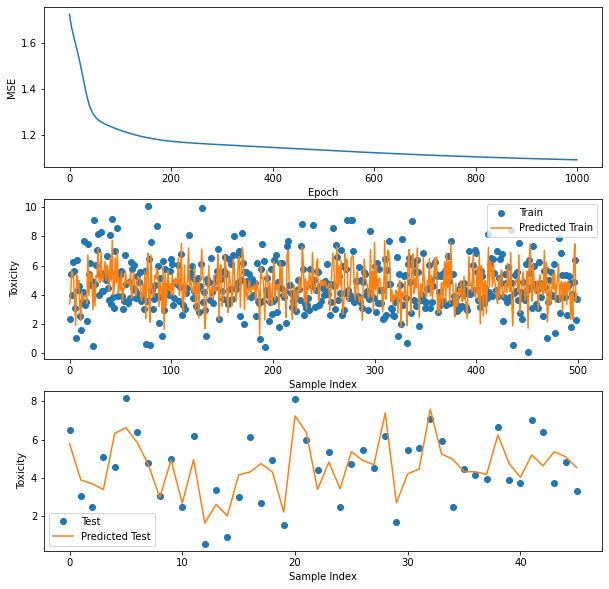

In [46]:
plot_uci('sgd', 1000,0.05,Xtrain,Ttrain,Xtest,Ttest,[5,5]) 

#### Vary n_hiddens_list, n_epochs and learning_rate for Adam

In [17]:
n_epochs_list=[500,1000,3000]
n_hiddens_listof_list=[[2,2],[5,5],[50,10,20]]
learning_rate_list=[0.05,0.1,0.3]
df12=run_uci('adam', n_epochs_list,learning_rate_list,Xtrain,Ttrain,Xtest,Ttest,n_hiddens_listof_list)

In [18]:
df12

,Learning Rate,Hidden Layers,Epochs,RMSE Train,RMSE Test
0,0.05,"[2, 2]",500,1.096916,1.215297
1,0.05,"[2, 2]",1000,1.103610,1.080940
2,0.05,"[2, 2]",3000,1.094975,1.090746
3,0.05,"[5, 5]",500,0.845404,1.397459
4,0.05,"[5, 5]",1000,0.792455,1.240936
5,0.05,"[5, 5]",3000,0.800368,1.467794
6,0.05,"[50, 10, 20]",500,0.285937,1.514475
7,0.05,"[50, 10, 20]",1000,0.230717,1.594502
8,0.05,"[50, 10, 20]",3000,0.121841,1.318678
9,0.10,"[2, 2]",500,1.071977,1.145947


shape of Ytrain is (500, 1)
shape of Xtrain is (500, 8)
shape of Ttrain is (500, 1)


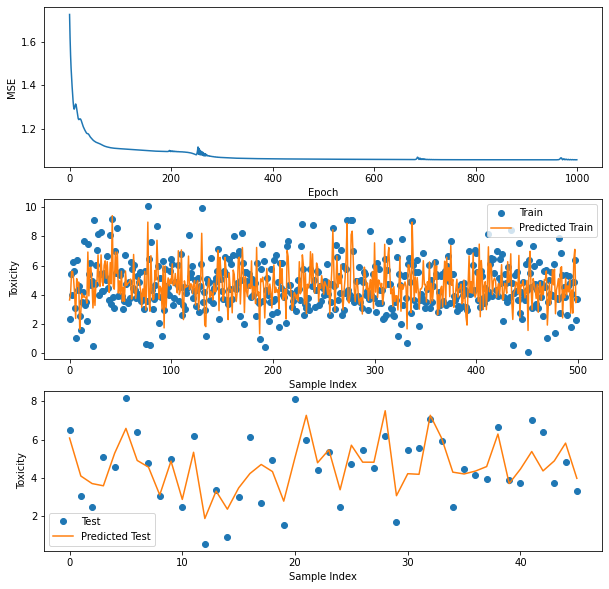

In [45]:
plot_uci('adam', 1000,0.05,Xtrain,Ttrain,Xtest,Ttest,[2,2])

#### Vary n_hiddens_list, n_epochs for SCG

In [20]:
n_epochs_list=[500,1000,3000]
n_hiddens_listof_list=[[2,2],[5,5],[50,10,20]]
learning_rate_list=[0]
df13=run_uci('scg', n_epochs_list,learning_rate_list,Xtrain,Ttrain,Xtest,Ttest,n_hiddens_listof_list)

In [21]:
df13

,Learning Rate,Hidden Layers,Epochs,RMSE Train,RMSE Test
0,0,"[2, 2]",500,1.065105,1.195836
1,0,"[2, 2]",1000,1.105069,1.103000
2,0,"[2, 2]",3000,1.072215,1.150835
3,0,"[5, 5]",500,0.835077,1.309568
4,0,"[5, 5]",1000,0.789936,1.128588
5,0,"[5, 5]",3000,0.788311,1.631939
6,0,"[50, 10, 20]",500,0.352855,1.587400
7,0,"[50, 10, 20]",1000,0.190555,1.815442
8,0,"[50, 10, 20]",3000,0.075202,3.025117


shape of Ytrain is (500, 1)
shape of Xtrain is (500, 8)
shape of Ttrain is (500, 1)


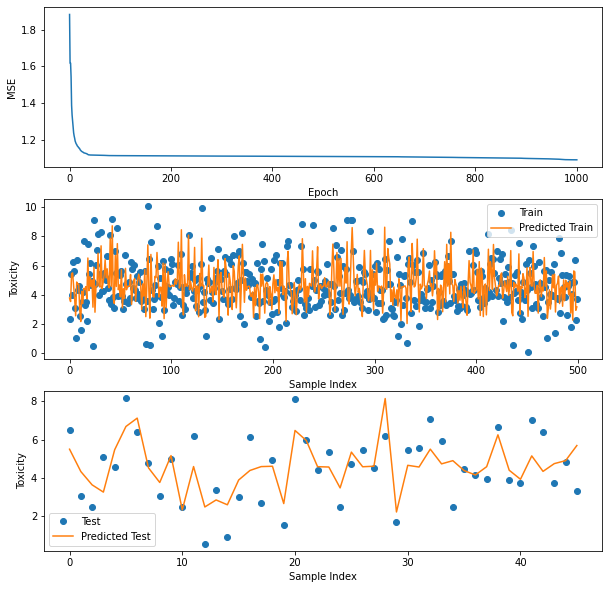

In [47]:
plot_uci('scg', 1000,0,Xtrain,Ttrain,Xtest,Ttest,[2,2])

### OBSERVATIONS

SGD and ADAM models were trained for the following variations in parameters:

    Epochs        : [500,1000,3000]
    Hidden Layers : [[2,2],[5,5],[50,10,20]]
    Learning Rate : [0.05,0.1,0.3]
    
SCG model was trained for the following variations in parameters:

    Epochs        : [500,1000,3000]
    Hidden Layers : [[2,2],[5,5],[50,10,20]]
    
===============================================================================================

The models had the least Test error for the following parameters:
 

--------------------------------------------------


Model : SGD  ====> HL :	[5, 5]	====>  Epochs : 1000 ====> LR : 0.05

Model : ADAM ====> HL : [2, 2]	====>  Epochs : 1000 ====> LR : 0.05

Model : SCG	 ====> HL : [2, 2]	====>  Epochs : 1000	     

--------------------------------------------------

1. Surprisingly, 1000 epochs, learning rate of 0.05 was the optimal parameters for both SGD and ADAM. This was inspite of ADAM's MSE dropping earlier than SGD. Similarly, SCG's MSE dropped the first to drop the lowest. Yet, it also took 1000 epochs to reach the minimum MSE.
2. It was interesting to observe that the lowest MSE was observed at 1000 epochs and not 3000 epochs. Thus, we can conclude that more number of epochs does not necessarily improve the model performance.
3. Both SCG and ADAM required only 2 hidden layers with 2 units in each to reach the best performance. But, both of them took 1000 epochs. It would be interesting to tweak the number of epochs keeping the other parameters constant (hidden layers [2,2] for both and LR of 0.05 for ADAM) and observe which requires least number of epochs to reach the best performance. Within this testing environment, we could then conclude that that particular mode is the best of similar datasets. 
4. It is very impressive that both ADAM and SCG required only 2 hidden layers with 2 units each. However, even though both of their test MSE values started dropping early, they both took 1000 epochs. So, it would be a good idea to tweak the learning rate (for ADAM) to see if the number of epochs can be reduced even further.
5. It is interesting to observe that all three models reached optimum performance with only 2 hidden layers.
6. If we observe the MSE curves, we can see that both SGD and SCG models' curves follow a linear path. ADAM's curve however has ups and downs before finally settling down to the lowest MSE value.
7. The least value of Test MSE(1.069996) among all models and all variations in parameters was observed for SGD model with hidden layers as [5,5] , 1000 epochs and learning rate 0.05.
8. The highest value of Test MSE(3.025117) among all models and all variations in parameters was observed for SCG model with hidden layers as [50,10,20] , 3000 epochs.
9. The model which gave the least Train RMSE was SCG with parameters : 3000 epochs and [50, 10, 20]. It is also interesting to observe that the same model with the same set of parameters gave the highest Test MSE. Hence, this implies significant overfitting during training. Thus, we can conclude that blindly increasing the number of hidden layers and the epochs will lead to overfittig.
	


# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 40 points will be based on other testing and the results you obtain and your discussions. 

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A3.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [23]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Gopinath-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
CRITICAL ERROR: Function named 'NeuralNetworks' is not defined
  Check the spelling and capitalization of the function name.

## Testing constructor ####################################################################

    nnet = NeuralNetwork(2, [5, 4], 3)
    W_shapes = [W.shape for W in nnet.Ws]


--- 5/5 points. W_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    G_shapes = [G.shape for G in nnet.Gs]


--- 5/5 points. G_shapes is correct value of [(3, 5), (6, 4), (5, 3)]

## Testing constructor ####################################################################

    nnet.Ws[0][2, 0] = 100.0
    # Does nnet.Ws[0][2, 0] == nnet.all_weights[10]


--

# Extra Credit

I chose the air quality dataset(https://archive.ics.uci.edu/ml/datasets/air+quality)

In [24]:
import numpy as np
import pandas

import matplotlib.pyplot as plt

import matplotlib.animation as animation
datap = pandas.read_csv('AirQualityUCI.csv', delimiter=';',decimal=',',usecols=range(15), na_values=-200)
datap = datap.dropna(axis=0)
datap=datap.drop(labels=['Date','Time'],axis=1)
datap=datap.to_numpy(dtype='float')


In [25]:
!wc AirQualityUCI.csv

  9472   9472 785065 AirQualityUCI.csv


In [26]:
np.shape(datap)

(827, 13)

In [27]:
datap.dtype

dtype('float64')

In [28]:
np.random.shuffle(datap)
datap[0]

array([1.100e+00, 9.220e+02, 6.500e+01, 3.400e+00, 6.740e+02, 6.300e+01,
       1.220e+03, 7.800e+01, 1.205e+03, 4.980e+02, 1.560e+01, 3.750e+01,
       6.575e-01])

In [29]:
datap.shape

(827, 13)

In [30]:
Xtrain1 = datap[0:744, 0:12]
Ttrain1 = datap[0:744, -1:]
Xtest1  = datap[744:827,0:12]
Ttest1  = datap[744:827,-1:]


In [31]:
Xtrain1.dtype

dtype('float64')

In [32]:
Xtrain1.shape, Ttrain1.shape,Xtest1.shape,Ttest1.shape

((744, 12), (744, 1), (83, 12), (83, 1))

In [33]:
Xtrain1[0]

array([1.100e+00, 9.220e+02, 6.500e+01, 3.400e+00, 6.740e+02, 6.300e+01,
       1.220e+03, 7.800e+01, 1.205e+03, 4.980e+02, 1.560e+01, 3.750e+01])

In [34]:
Ttrain1[0]

array([0.6575])

#### Vary n_hiddens_list, n_epochs and learning_rate for SGD

In [35]:
n_epochs_list=[500,1000,3000]
n_hiddens_listof_list=[[2,2],[5,5],[50,10,20]]
learning_rate_list=[0.05,0.1,0.3]
df11_1=run_uci('sgd', n_epochs_list,learning_rate_list,Xtrain1,Ttrain1,Xtest1,Ttest1,n_hiddens_listof_list)


In [36]:
df11_1

,Learning Rate,Hidden Layers,Epochs,RMSE Train,RMSE Test
0,0.05,"[2, 2]",500,0.051664,0.061198
1,0.05,"[2, 2]",1000,0.036948,0.043414
2,0.05,"[2, 2]",3000,0.043396,0.057125
3,0.05,"[5, 5]",500,0.041820,0.050868
4,0.05,"[5, 5]",1000,0.023252,0.034170
5,0.05,"[5, 5]",3000,0.011922,0.018771
6,0.05,"[50, 10, 20]",500,0.030764,0.038826
7,0.05,"[50, 10, 20]",1000,0.019484,0.031258
8,0.05,"[50, 10, 20]",3000,0.008812,0.013339
9,0.10,"[2, 2]",500,0.041555,0.051895


shape of Ytrain is (744, 1)
shape of Xtrain is (744, 12)
shape of Ttrain is (744, 1)


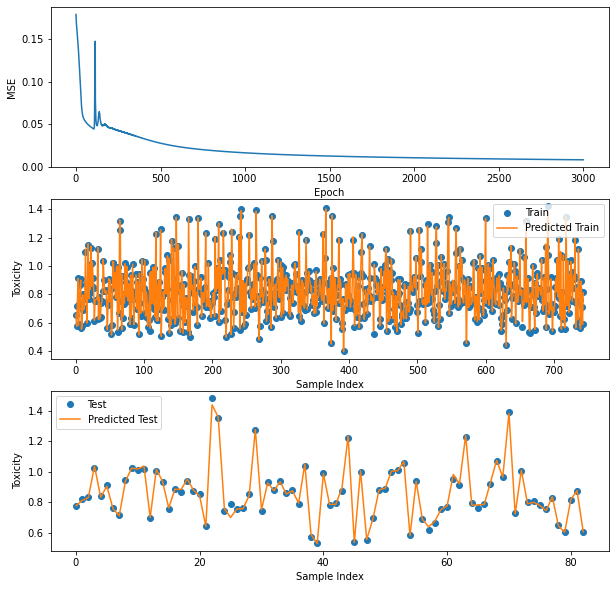

In [48]:
plot_uci('sgd', 3000,0.05,Xtrain1,Ttrain1,Xtest1,Ttest1,[50,10,20])

#### Vary n_hiddens_list, n_epochs and learning_rate for Adam

In [38]:
n_epochs_list=[500,1000,3000]
n_hiddens_listof_list=[[2,2],[5,5],[50,10,20]]
learning_rate_list=[0.05,0.1,0.3]
df12_1=run_uci('adam', n_epochs_list,learning_rate_list,Xtrain1,Ttrain1,Xtest1,Ttest1,n_hiddens_listof_list)


In [39]:
df12_1

,Learning Rate,Hidden Layers,Epochs,RMSE Train,RMSE Test
0,0.05,"[2, 2]",500,0.014082,0.020351
1,0.05,"[2, 2]",1000,0.021277,0.035783
2,0.05,"[2, 2]",3000,0.017857,0.021106
3,0.05,"[5, 5]",500,0.003971,0.008606
4,0.05,"[5, 5]",1000,0.003575,0.006431
5,0.05,"[5, 5]",3000,0.007048,0.008223
6,0.05,"[50, 10, 20]",500,0.004092,0.016485
7,0.05,"[50, 10, 20]",1000,0.003080,0.011586
8,0.05,"[50, 10, 20]",3000,0.004508,0.010779
9,0.10,"[2, 2]",500,0.019118,0.032446


shape of Ytrain is (744, 1)
shape of Xtrain is (744, 12)
shape of Ttrain is (744, 1)


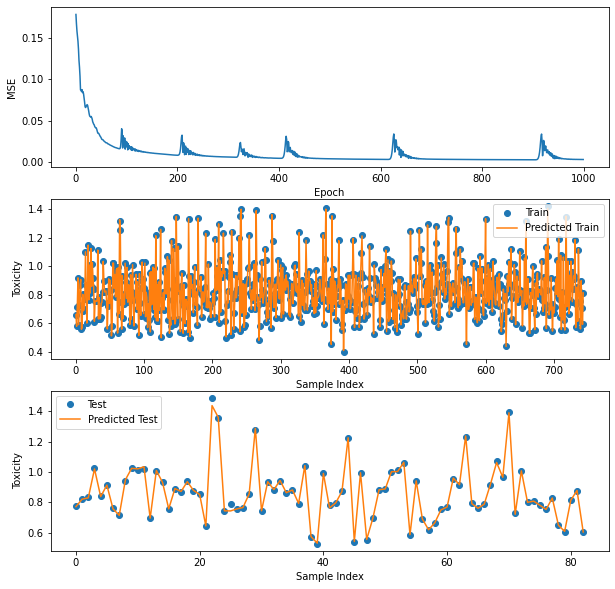

In [49]:
plot_uci('adam', 1000,0.05,Xtrain1,Ttrain1,Xtest1,Ttest1,[5,5])

#### Vary n_hiddens_list, n_epochs for SCG

In [41]:
n_epochs_list=[500,1000,3000]
n_hiddens_listof_list=[[2,2],[5,5],[50,10,20]]
learning_rate_list=[0]
df13_1=run_uci('scd', n_epochs_list,learning_rate_list,Xtrain1,Ttrain1,Xtest1,Ttest1,n_hiddens_listof_list)

In [42]:
df13_1

,Learning Rate,Hidden Layers,Epochs,RMSE Train,RMSE Test
0,0,"[2, 2]",500,0.171887,0.182127
1,0,"[2, 2]",1000,0.207241,0.232261
2,0,"[2, 2]",3000,0.172929,0.178700
3,0,"[5, 5]",500,0.190051,0.190812
4,0,"[5, 5]",1000,0.177476,0.179719
5,0,"[5, 5]",3000,0.192510,0.189674
6,0,"[50, 10, 20]",500,0.176499,0.186227
7,0,"[50, 10, 20]",1000,0.183502,0.202074
8,0,"[50, 10, 20]",3000,0.180624,0.192891


shape of Ytrain is (744, 1)
shape of Xtrain is (744, 12)
shape of Ttrain is (744, 1)


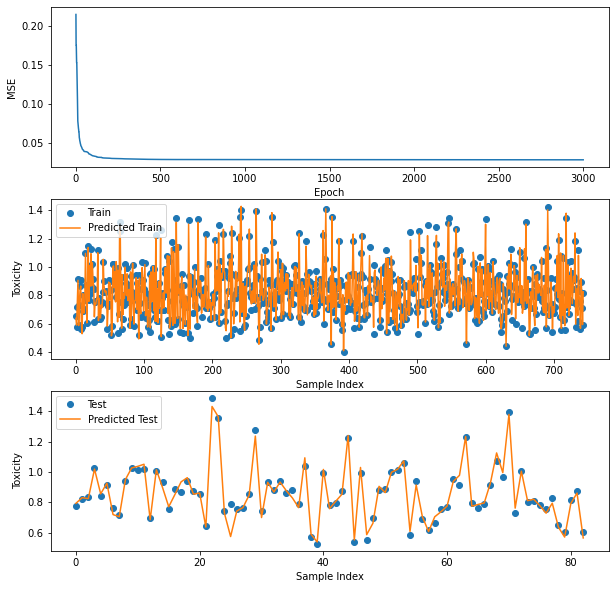

In [50]:
plot_uci('scg', 3000,0,Xtrain1,Ttrain1,Xtest1,Ttest1,[2,2])

### OBSERVATIONS

The performance pattern of the 3 models for the Air quality dataset is similar to the Aquatic dataset. This is because both the datasets are similar in that they contain readings(toxicity related) over different periods of time.
But, from the Test graphs, we can observe that the prediction is better for this dataset as compared to the Aquatic dataset. This could be because the readings are more consistent which is more of an environmental feature rather than it being due to the models performing better for this dataset.